# Case Study : Credit Card Approval Prediction (Developing a Machine Learning Model for Credit Scoring)

   
## Background:

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.   

## Detail Data Description : 

### 1. Data Sheet1: application_record.csv

ID                  : Client number
CODE_GENDER         : Gender
FLAG_OWN_CAR        : Is there a car
FLAG_OWN_REALTY     : Is there a property
CNT_CHILDREN        : Number of children
AMT_INCOME_TOTAL    : Annual income
NAME_INCOME_TYPE    : Income category
NAME_EDUCATION_TYPE : Education level
NAME_FAMILY_STATUS  : Marital status
NAME_HOUSING_TYPE   : Way of living
DAYS_BIRTH          : Birthday (Count backwards from current day (0), -1 means yesterday)
DAYS_EMPLOYED       : Start date of employment (Count backwards from current day(0). If positive, it means the person                                 currently unemployed.)
FLAG_MOBIL          : Is there a mobile phone
FLAG_WORK_PHONE     : Is there a work phone
FLAG_PHONE          : Is there a phone
FLAG_EMAIL          : Is there an email
OCCUPATION_TYPE     : Occupation
CNT_FAM_MEMBERS     : Family size

### 2. Data Sheet2: credit_record.csv

ID                  : Client number
MONTHS_BALANCE      : Record month (The month of the extracted data is the starting point, backwards, 0 is the current month,                         -1 is the previous month, and so on)
STATUS              : Status (0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4:                             120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month                           X: No loan for the month)

### Objective:

The goal is to build a machine learning model to predict whether a credit card applicant is a 'good' or 'bad' client. This involves:

1. Exploratory data analysis (EDA) to understand and preprocess the data
2. Developing a logistic regression model as a baseline.
3. Implementing advanced machine learning models.
4. Comparing their performance and interpretabilit.


#### Define Hypotheses:

**Null Hypothesis (H0)**: The credit card applicant is a 'good' client. This means that, based on the available data and the trained model, there is no significant evidence to suggest that the applicant will default.

**Alternative Hypothesis (H1)**: The credit card applicant is a 'bad' client. This means that there is significant evidence, based on the model, to suggest that the applicant will default.

In [698]:
pip install xgboost


In [699]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [700]:
pip install --upgrade imbalanced-learn scikit-learn

In [629]:
# loading libraries

# general libraries
import pandas as pd
import os
import numpy as np

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

# stats libraries
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


#Handel imblanced data
from sklearn.preprocessing import StandardScaler , LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC


### Import Data from Application Record & Credit Record

In [630]:
df_application_record = pd.read_csv('C:\Personal\Imperial College\Cerificate in Data Analytics\Capston Project\Data Set\Credit Card Approval Predictions/application_record.csv')
df_credit_record = pd.read_csv('C:\Personal\Imperial College\Cerificate in Data Analytics\Capston Project\Data Set\Credit Card Approval Predictions/credit_record.csv')


## Data Check

In [631]:
# Identify the total number of rows and columns from the imported sheets.

print('Total number of rows and columns of credit card application', df_application_record.shape)
print('Total number of rows and columns of credit score', df_credit_record.shape)

Total number of rows and columns of credit card application (438557, 18)
Total number of rows and columns of credit score (1048575, 3)


In [632]:
type(df_application_record)
type(df_credit_record)

pandas.core.frame.DataFrame

In [633]:
df_application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [634]:
df_credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [635]:
# Identify the column Names

df_application_record.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [636]:
# Identify the column Names

df_credit_record.columns

Index(['ID', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [637]:
df_application_record.index

RangeIndex(start=0, stop=438557, step=1)

In [638]:
df_credit_record.index

RangeIndex(start=0, stop=1048575, step=1)

In [639]:
# Identify the detail information on data set

df_application_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [640]:
df_credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [641]:
df_application_record.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [642]:
# Idenitfy the duplication

df_application_record.duplicated().sum()

0

In [643]:
df_credit_record.duplicated().sum()

0

In [644]:
# Identify the null values

df_application_record.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [645]:
df_application_record = df_application_record.drop(['FLAG_MOBIL', 'FLAG_EMAIL'], axis=1)

In [646]:
df_credit_record.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [647]:
df_credit_record.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

## EDA & Data Preparation

### Data Cleaning

There are duplicate IDs because of the Months_Balance column. Additionally, it is observed that the Months_Balance and Status values are interdependent. The system predicts whether a client is good or bad for credit card approval based on the Status column. Without removing the duplicate records, the system may predict both good and bad statuses for the same ID.

In [648]:
df_credit_record_clean = df_credit_record.groupby(["ID", "STATUS"], as_index=False).agg(status_count=("MONTHS_BALANCE", "count"))
df_credit_record_clean

,ID,STATUS,status_count
0,5001711,0,3
1,5001711,X,1
2,5001712,0,10
3,5001712,C,9
4,5001713,X,22
...,...,...,...
94138,5150483,X,18
94139,5150484,0,12
94140,5150484,C,1
94141,5150485,0,2


In [649]:
df_credit_record_clean['ranked_status'] = df_credit_record_clean.groupby("ID")["status_count"].transform(lambda x: x.rank(method='first', ascending=False))

In [650]:
df_credit_record_clean

,ID,STATUS,status_count,ranked_status
0,5001711,0,3,1.0
1,5001711,X,1,2.0
2,5001712,0,10,1.0
3,5001712,C,9,2.0
4,5001713,X,22,1.0
...,...,...,...,...
94138,5150483,X,18,1.0
94139,5150484,0,12,1.0
94140,5150484,C,1,2.0
94141,5150485,0,2,1.0


In [651]:
df_credit_record_clean.query("ranked_status == 1")

,ID,STATUS,status_count,ranked_status
0,5001711,0,3,1.0
2,5001712,0,10,1.0
4,5001713,X,22,1.0
5,5001714,X,15,1.0
6,5001715,X,60,1.0
...,...,...,...,...
94136,5150482,0,12,1.0
94138,5150483,X,18,1.0
94139,5150484,0,12,1.0
94141,5150485,0,2,1.0


In [652]:
final_data = df_credit_record_clean.query("ranked_status == 1").drop(columns = ["status_count", "ranked_status"], axis = 1)
final_data.shape

(45985, 2)

In [653]:
# Merge both the data sets to proceed further data processing

df = pd.merge(df_application_record, final_data, on = 'ID', how = 'inner')


In [654]:
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,NaN,2.0,C
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,NaN,2.0,C
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,Security staff,2.0,X
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,Sales staff,1.0,X
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,Sales staff,1.0,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,0,0,Managers,2.0,X
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,0,1,Medicine staff,2.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,0,1,Medicine staff,2.0,C
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,0,0,Sales staff,2.0,0


In [655]:
print('Total number of rows and columns of credit card application', df_application_record.shape)
print('Total number of rows and columns of credit score', final_data.shape)
print('Total number of rows and columns of merged data set', df.shape)


Total number of rows and columns of credit card application (438557, 16)
Total number of rows and columns of credit score (45985, 2)
Total number of rows and columns of merged data set (36457, 17)


In [656]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_WORK_PHONE      36457 non-null  int64  
 13  FLAG_PHONE           36457 non-null  int64  
 14  OCCUPATION_TYPE      25134 non-null  object 
 15  CNT_FAM_MEMBERS      36457 non-null 

In [657]:
df.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
OCCUPATION_TYPE           18
CNT_FAM_MEMBERS           10
STATUS                     6
dtype: int64

In [658]:
df.duplicated().sum()

0

In [659]:
df.isna().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
STATUS                     0
dtype: int64

In [660]:
df["NAME_INCOME_TYPE"].value_counts()

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64

**Unique Values of each column and Counts

In [661]:
df["NAME_EDUCATION_TYPE"].value_counts()

Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64

In [662]:
df["NAME_FAMILY_STATUS"].value_counts()

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64

In [663]:
df["NAME_HOUSING_TYPE"].value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64

In [664]:
df["OCCUPATION_TYPE"].value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

**Observation:

1. There are only one column in our datafrme which has null values.
2. This column is OCCUPATION_TYPE and it has 240048 missing values and it has percentage of 30.86% missing values
 

In [665]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'STATUS'],
      dtype='object')

In [666]:

df_copy = df.copy()

In [667]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,0.225526,0.294813,2.198453
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.417934,0.455965,0.911686
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,0.000000,1.000000,3.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.000000,1.000000,20.000000


In [668]:
# ID is an Unique column which used for unique identification of the clients. 
# We don't required the statistical details for this column.


df_ID_Exclude = df_copy.drop(columns = 'ID')

df_ID_Exclude.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,36457.000000,0.430315,0.742367,0.000000,0.000000,0.000000,1.000000,19.000000
AMT_INCOME_TOTAL,36457.000000,186685.736662,101789.226482,27000.000000,121500.000000,157500.000000,225000.000000,1575000.000000
DAYS_BIRTH,36457.000000,-15975.173382,4200.549944,-25152.000000,-19438.000000,-15563.000000,-12462.000000,-7489.000000
DAYS_EMPLOYED,36457.000000,59262.935568,137651.334859,-15713.000000,-3153.000000,-1552.000000,-408.000000,365243.000000
FLAG_WORK_PHONE,36457.000000,0.225526,0.417934,0.000000,0.000000,0.000000,0.000000,1.000000
FLAG_PHONE,36457.000000,0.294813,0.455965,0.000000,0.000000,0.000000,1.000000,1.000000
CNT_FAM_MEMBERS,36457.000000,2.198453,0.911686,1.000000,2.000000,2.000000,3.000000,20.000000


In [669]:
df[df['DAYS_EMPLOYED']>= 0]['DAYS_EMPLOYED'].value_counts()

365243    6135
Name: DAYS_EMPLOYED, dtype: int64

In [670]:
df['YEARS_AGE'] = round(-df['DAYS_BIRTH'] / 365.25)

In [671]:
df['YEARS_AGE']

0        33.0
1        33.0
2        59.0
3        52.0
4        52.0
         ... 
36452    47.0
36453    34.0
36454    34.0
36455    49.0
36456    25.0
Name: YEARS_AGE, Length: 36457, dtype: float64

In [672]:
df['YEARS_EMPLOYED'] = round(-df['DAYS_EMPLOYED'] / 365.25)
df.loc[df['YEARS_EMPLOYED'] < 0, 'YEARS_EMPLOYED'] = 0

In [673]:
df[df['YEARS_EMPLOYED']<=0]['YEARS_EMPLOYED'].value_counts()

0.0    7040
Name: YEARS_EMPLOYED, dtype: int64

In [674]:
df.drop(columns = ["DAYS_BIRTH", "DAYS_EMPLOYED"], inplace = True)

In [675]:
df.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
ID,36457.00,5078227.00,41875.24,5008804.00,5042028.00,5074614.00,5115396.00,5150487.00
CNT_CHILDREN,36457.00,0.43,0.74,0.00,0.00,0.00,1.00,19.00
AMT_INCOME_TOTAL,36457.00,186685.74,101789.23,27000.00,121500.00,157500.00,225000.00,1575000.00
FLAG_WORK_PHONE,36457.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00
FLAG_PHONE,36457.00,0.29,0.46,0.00,0.00,0.00,1.00,1.00
CNT_FAM_MEMBERS,36457.00,2.20,0.91,1.00,2.00,2.00,3.00,20.00
YEARS_AGE,36457.00,43.75,11.51,21.00,34.00,43.00,53.00,69.00
YEARS_EMPLOYED,36457.00,6.04,6.49,0.00,1.00,4.00,9.00,43.00


In [677]:
# Transferring the Status value

df['LOAN_STATUS'] = df['STATUS'].map({'0' : '1st Month Overdue', '1' : '2nd Month Overdue', '2' : '3rd Month Overdue',
                                    '3' : '4th Month Overdue', '4' : '5th Month Overdue', '5' : 'Overdue / Bad Debts',
                                    'C' : 'Good', 'X': 'No Loan'})

### Check Relationship in Data

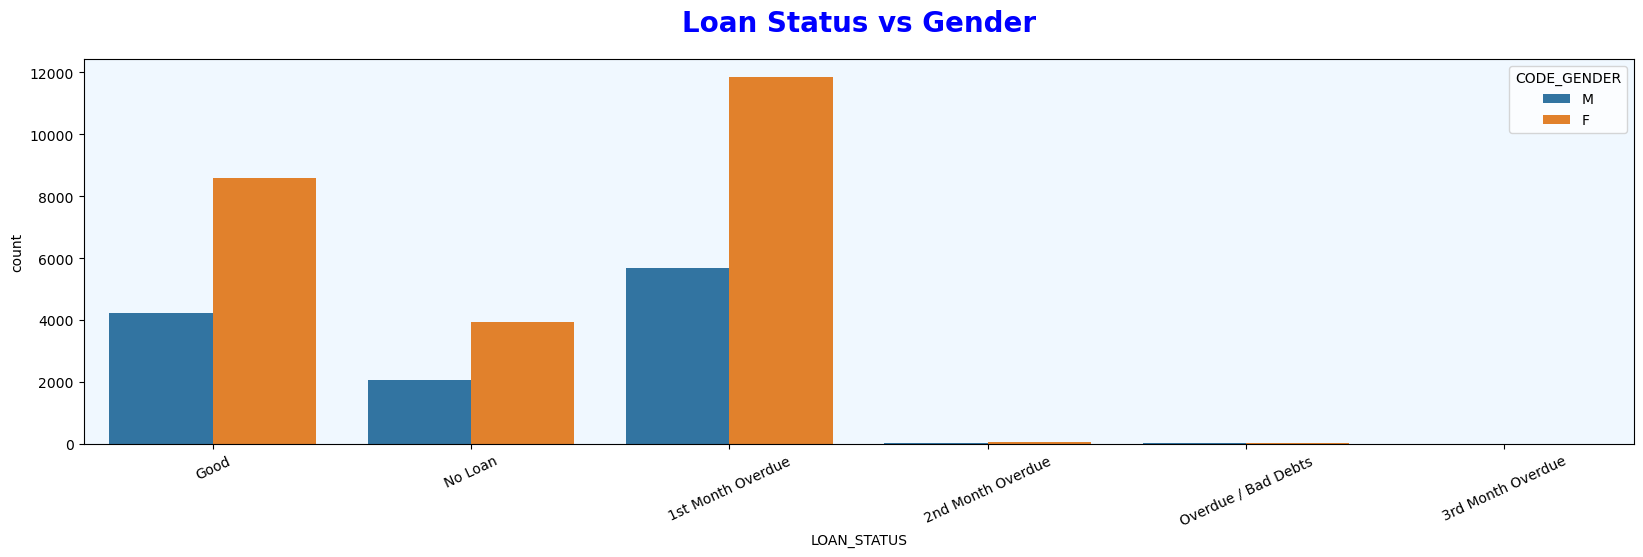

In [678]:
# checking the relationship between loan status and gender

LoanStatus_Gender = df.groupby('LOAN_STATUS')['CODE_GENDER'].value_counts().unstack()
#print(LoanStatus_Gender)

# defining the figure size
plt.figure(figsize=(20, 5))

# plotting the countplot
sns.countplot(data=df, x=df['LOAN_STATUS'], hue=df['CODE_GENDER'])

# Adding a title
plt.title('Loan Status vs Gender', fontsize=20, fontweight='bold', color="blue",pad=20, loc='center')  # 'loc' centers the title, 'pad' adds padding

# rotating the x-axis labels
plt.xticks(rotation=25)

# Changing the plot area background color
plt.gca().set_facecolor('#f0f8ff')  # set_facecolor sets the background color of the plot area

# Displaying the plot
plt.show()

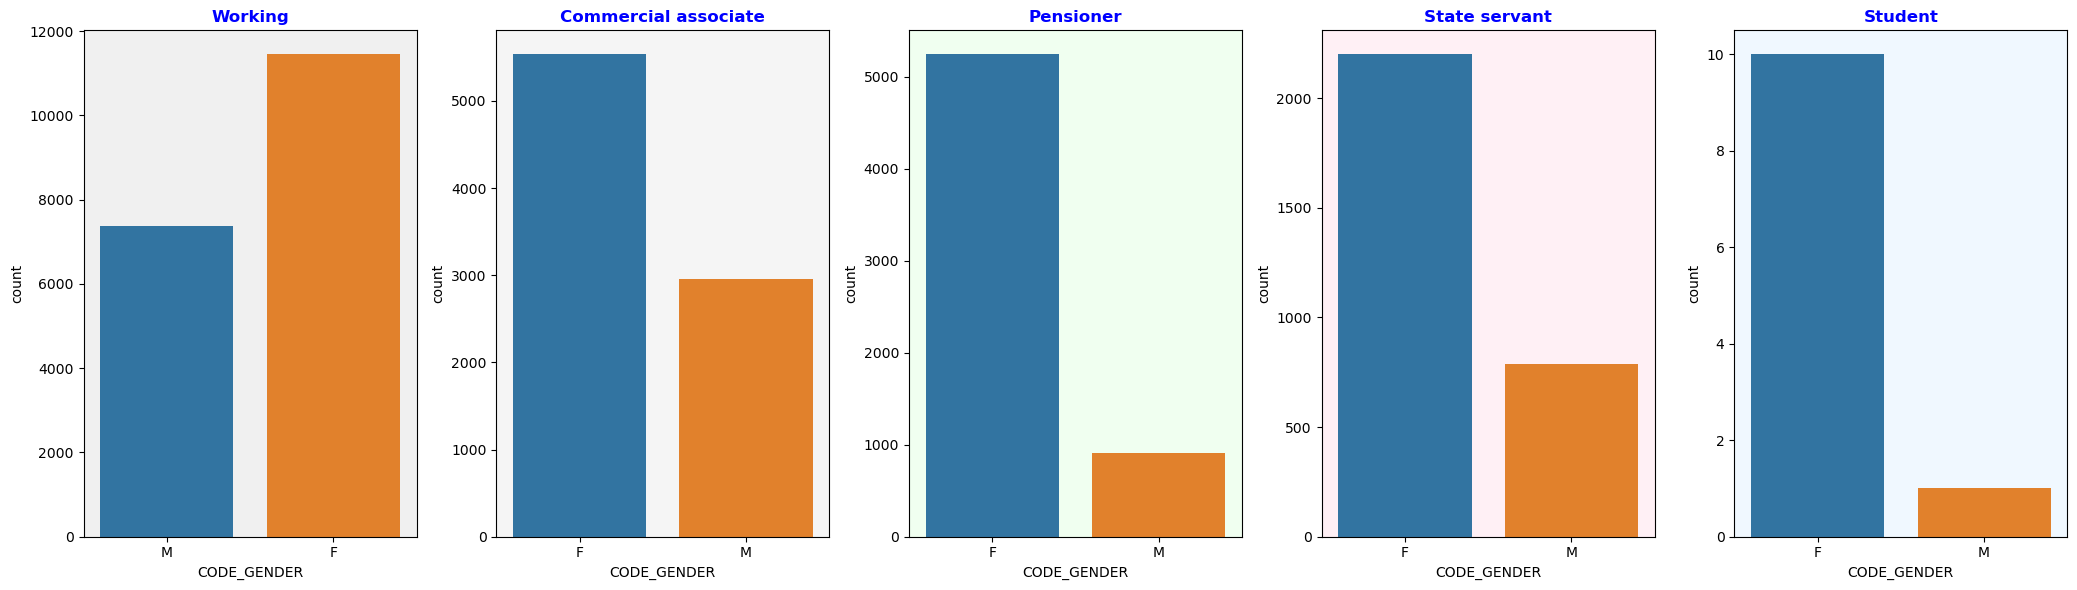

In [679]:
# Grouping data and creating the DataFrame (assuming df is already defined)

IncomeType_Gender = df.groupby('NAME_INCOME_TYPE')['CODE_GENDER'].value_counts().unstack()

# Getting the counts of each 'NAME_INCOME_TYPE'
IncomeType_Count = df['NAME_INCOME_TYPE'].value_counts()

plt.figure(figsize=(25, 6))

# Defining colors for plot areas
plot_colors = ['#f0f0f0', '#f5f5f5', '#f0fff0', '#fff0f5', '#f0f8ff', '#fffaf0']

# Plotting the countplot for each unique value of 'income_type'

for i in range(len(IncomeType_Count)):
    plt.subplot(1, 6, i+1)  # Adjusting the subplot layout for all plots in a single row
    
    # Setting background color for each subplot
    plt.gca().set_facecolor(plot_colors[i])
    
    # Plotting countplot
    sns.countplot(data=df[df['NAME_INCOME_TYPE'] == IncomeType_Count.index[i]], x='CODE_GENDER')
    
    # Use the unique value of 'income_type' as the title
    plt.title(IncomeType_Count.index[i])
        
    # Setting title
    plt.title(IncomeType_Count.index[i], fontweight='bold', color="blue")

plt.tight_layout()
plt.show()


### Observations:

1. The ratio of females is higher than that of males in both loan status and occupation categories.
2. The data is imbalanced concerning loan status, with very few records for "2nd month Overdue," "3rd month Overdue," and "Overdue/Bad debts."

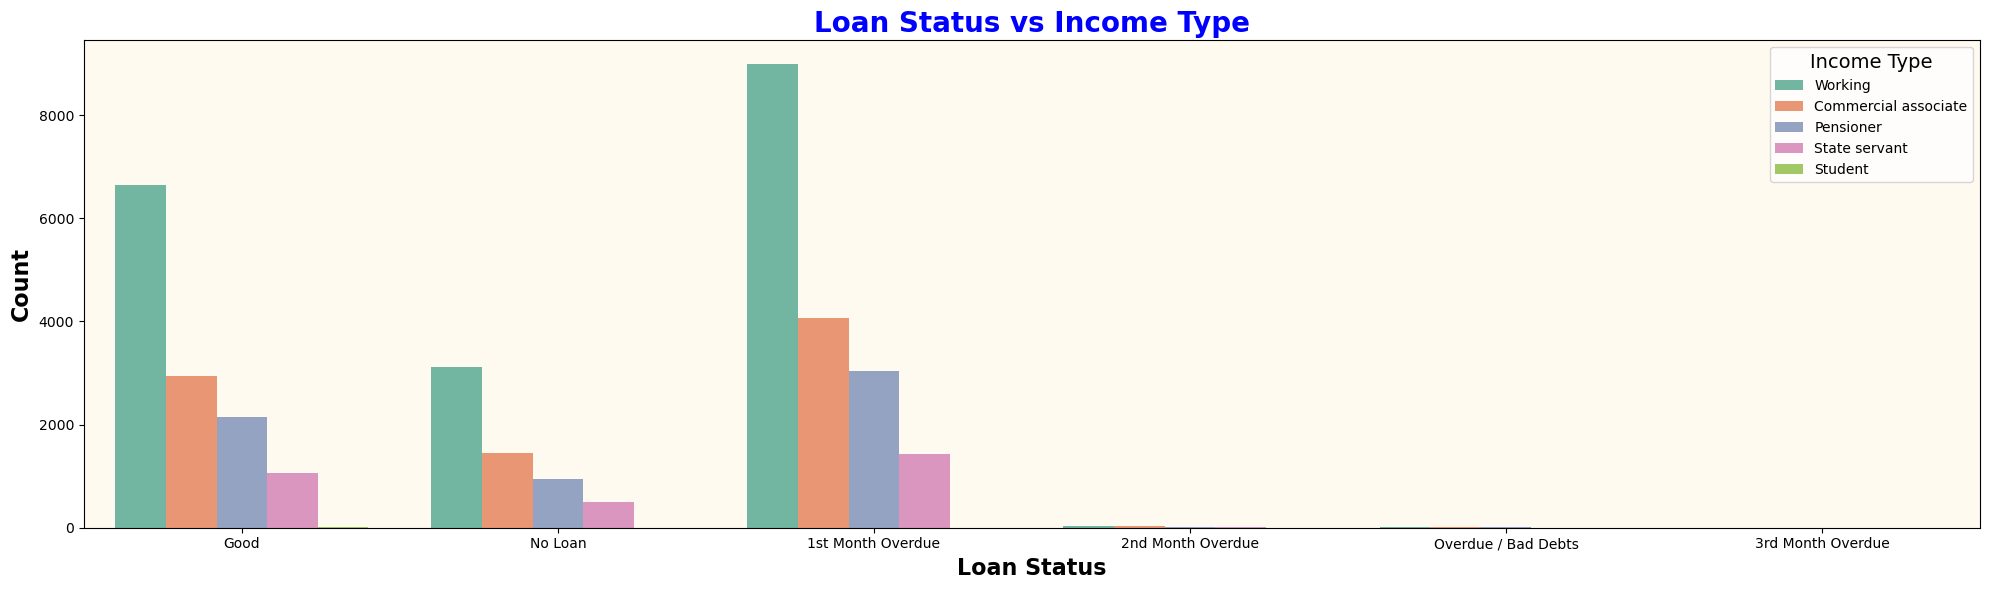

In [680]:
# Grouping data and creating the DataFrame (assuming df is already defined)
LoanStatus_IncomeType = df.groupby('LOAN_STATUS')['NAME_INCOME_TYPE'].value_counts().unstack()

# Defining figure size and creating the plot
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='LOAN_STATUS', hue='NAME_INCOME_TYPE', palette='Set2')  # Adjust palette as needed

# Adding title and labels
plt.title('Loan Status vs Income Type', fontsize=20, fontweight='bold', color="blue")
plt.xlabel('Loan Status', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')

# # Rotating x-axis labels
# #plt.xticks(rotation=25)

# Adding legend with adjusted position
plt.legend(title='Income Type', title_fontsize='14', loc='upper right')

# Changing the plot area background color
plt.gca().set_facecolor('#fffaf0')

# Adjusting layout to prevent overlap
plt.tight_layout()

# Displaying the plot
plt.show()


<Figure size 2000x900 with 0 Axes>

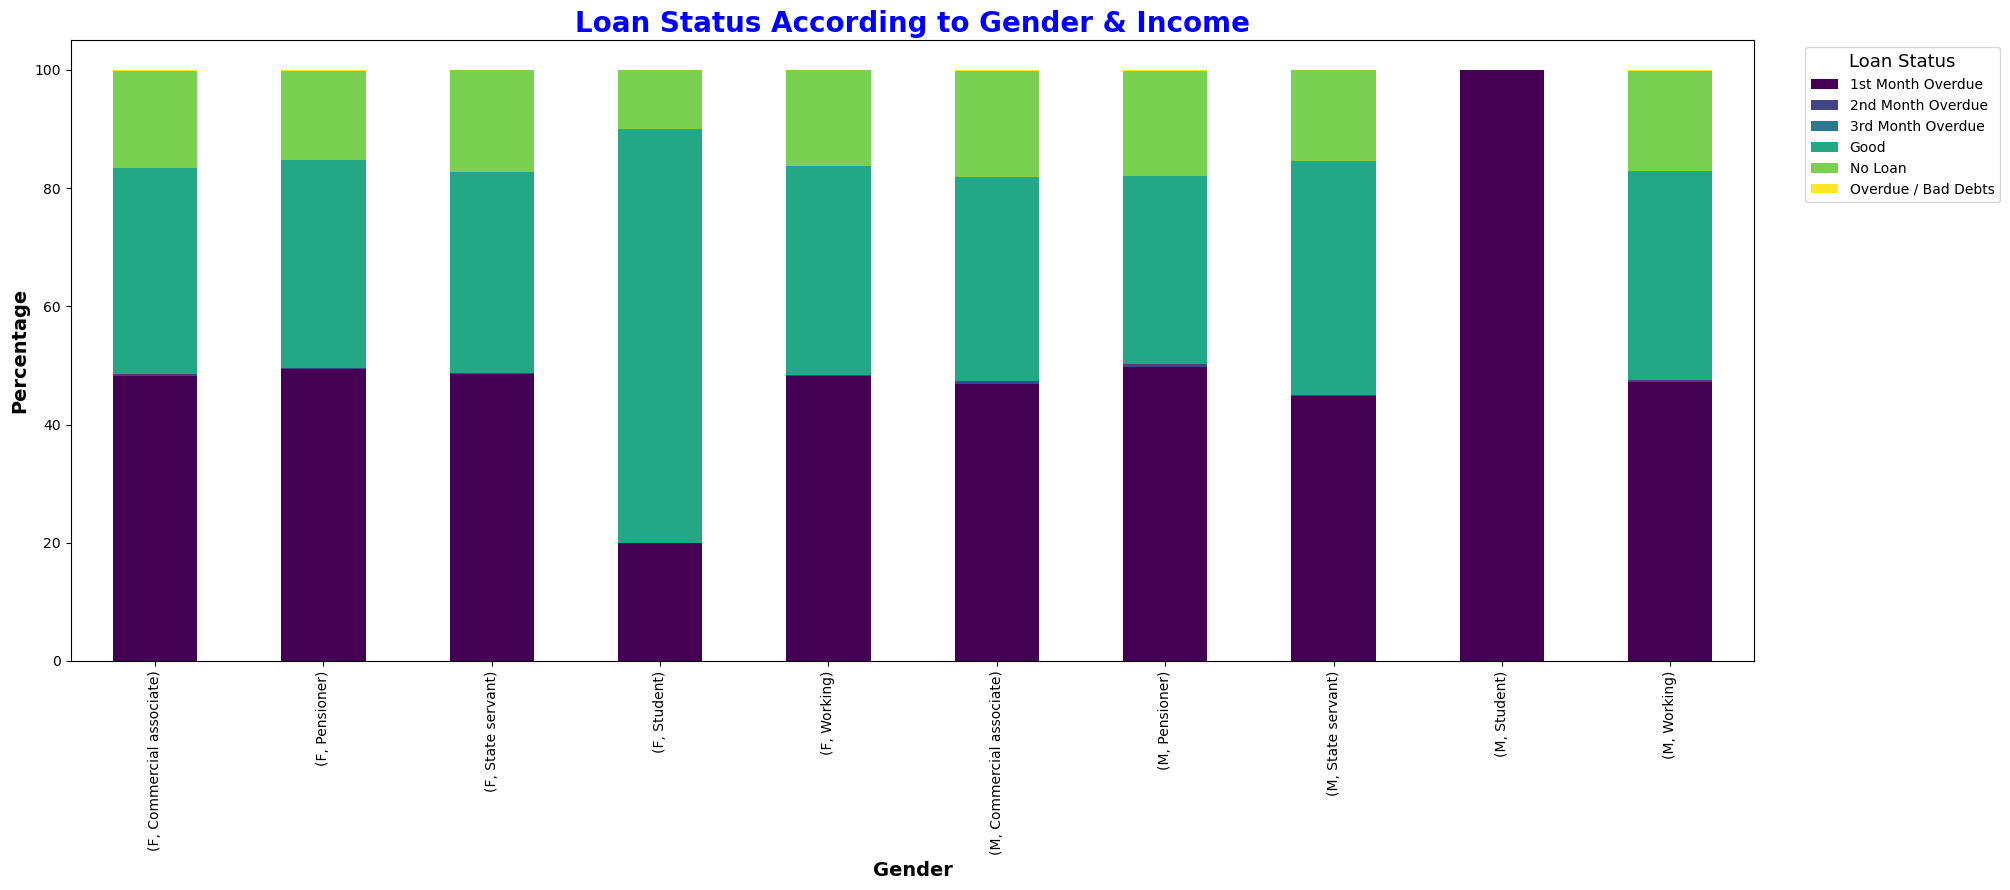

In [681]:
#Grouping data and creating the DataFrame (assuming df is already defined)
LoanStatus_IncomeType = df.groupby(['CODE_GENDER', 'NAME_INCOME_TYPE'])['LOAN_STATUS'].value_counts().unstack()

# Calculate percentages
LoanStatus_IncomeType_percent = LoanStatus_IncomeType.div(LoanStatus_IncomeType.sum(axis=1), axis=0) * 100

# Plotting the 100% stacked bar chart
plt.figure(figsize=(20, 9))
LoanStatus_IncomeType_percent.plot(kind='bar', stacked=True, figsize=(20, 9), cmap='viridis')

# Adding title and adjusting legend
plt.title('Loan Status According to Gender & Income', fontsize=20, fontweight='bold', color="blue")
plt.xlabel('Gender', fontsize=14, fontweight='bold')
plt.ylabel('Percentage', fontsize=14, fontweight='bold')

# Moving the legend outside the plot area
plt.legend(title='Loan Status', title_fontsize='13', loc='upper right', bbox_to_anchor=(1.15, 1))

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()

### Observations:

1. Except for students, "1st Month Overdue," "Good," and "No Loan" statuses are properly distributed between males and females.
2. Female students have a better loan status compared to male students.

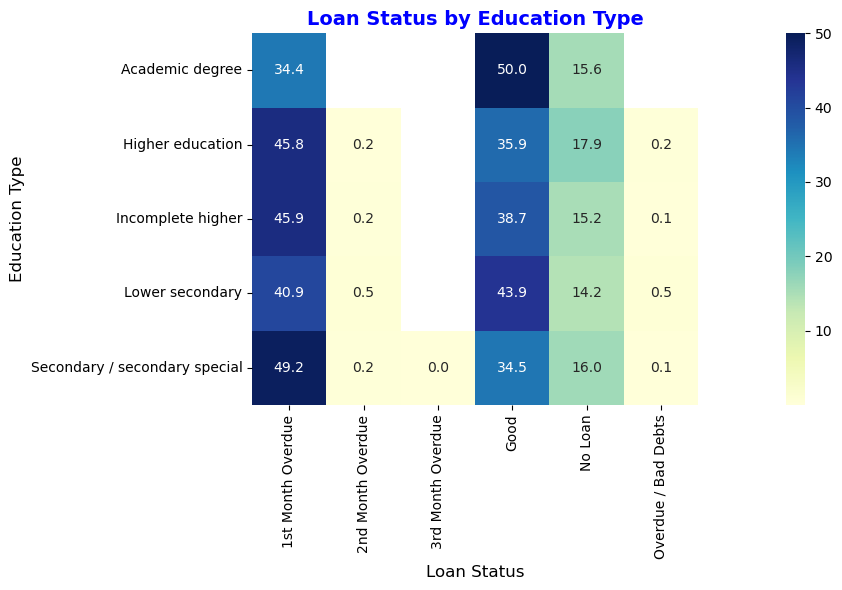

In [682]:
# Calculate the counts of LOAN_STATUS by NAME_EDUCATION_TYPE
education_Loanstatus = df.groupby('NAME_EDUCATION_TYPE')['LOAN_STATUS'].value_counts(normalize=True).unstack() * 100

# Plotting the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(education_Loanstatus, annot=True, fmt='.1f', cmap='YlGnBu', square=True, cbar_kws={'orientation': 'vertical'})

# Adding title and labels
plt.title('Loan Status by Education Type', fontsize=14, fontweight='bold', color="blue")
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Education Type', fontsize=12)

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()

### Observations:

The heatmap indicates that education categories have a strong positive relationship with the "1st Month Overdue" and "Good" loan statuses. There is also a noticeable relationship with the "No Loan" status. 
Conversely, there is a negative relationship with "2nd Month Overdue," "3rd Month Overdue," and "Overdue/Bad Debts" statuses.

This observation highlights the potential predictive value of education, income type, and loan status in machine learning models focused on predicting loan outcomes.

<Figure size 1800x900 with 0 Axes>

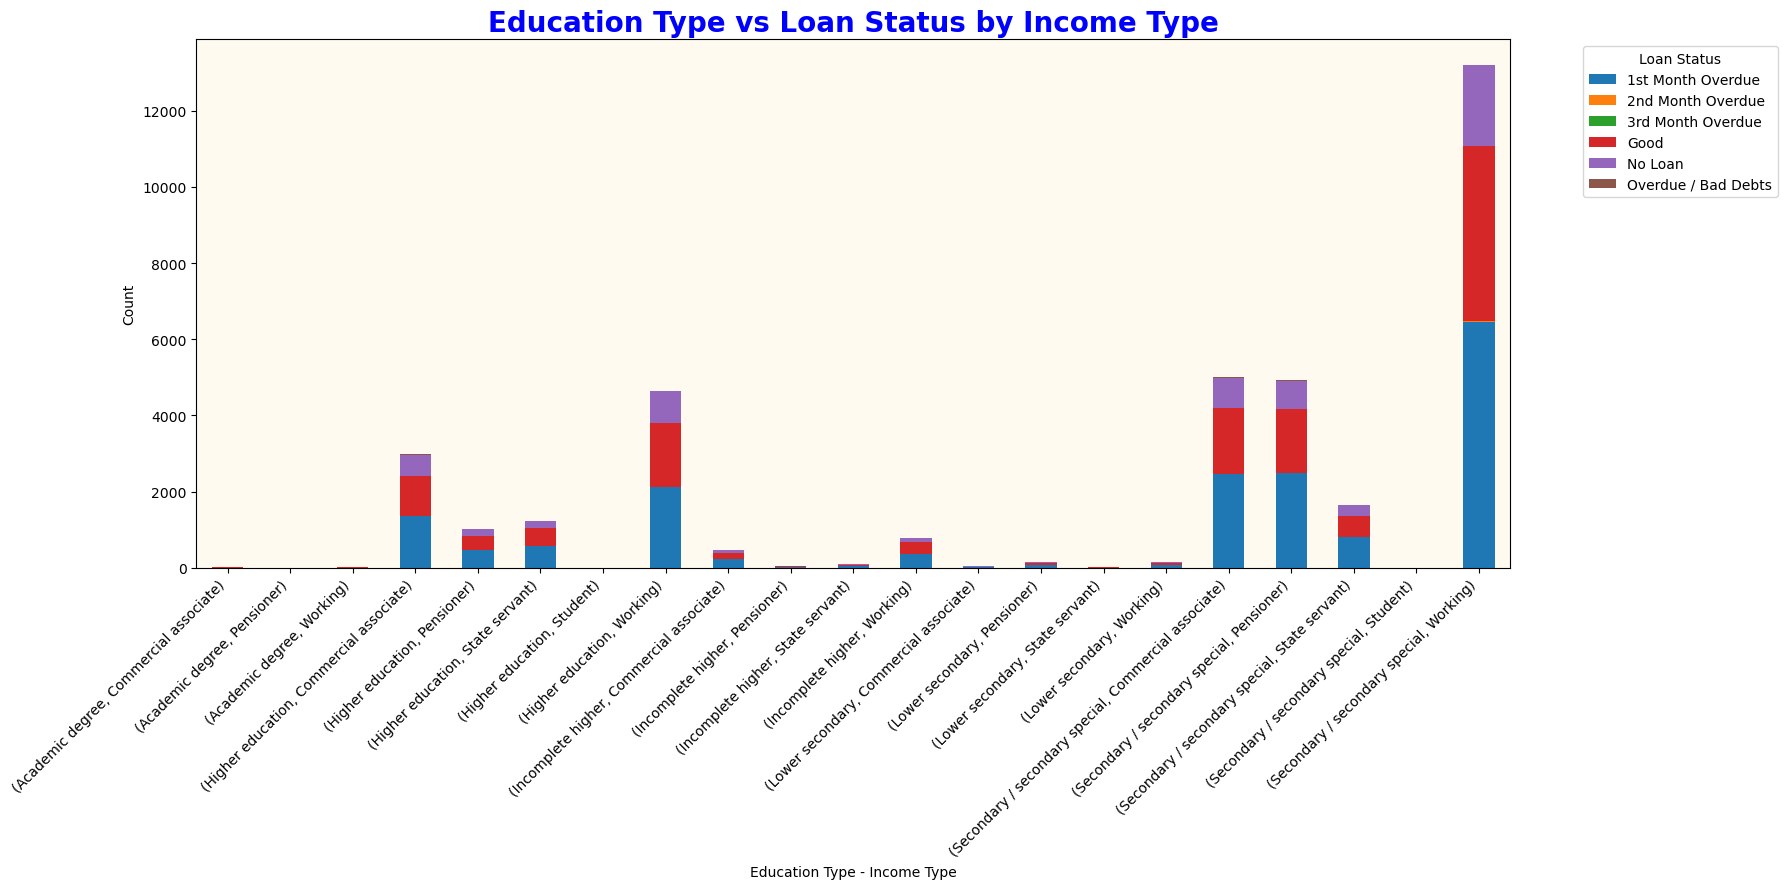

In [683]:
# Grouping and counting occurrences
grouped_counts = df.groupby(['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'LOAN_STATUS']).size().reset_index(name='COUNT')

# Pivot table for stacked bar chart
pivot_table = grouped_counts.pivot_table(index=['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE'], columns='LOAN_STATUS', values='COUNT', fill_value=0)

# Plotting stacked bar chart
plt.figure(figsize=(18, 9))
pivot_table.plot(kind='bar', stacked=True, figsize=(18, 9))
plt.title('Education Type vs Loan Status by Income Type', fontsize=20, fontweight='bold', color="blue")
plt.xlabel('Education Type - Income Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.gca().set_facecolor('#fffaf0')

plt.tight_layout()
plt.show()

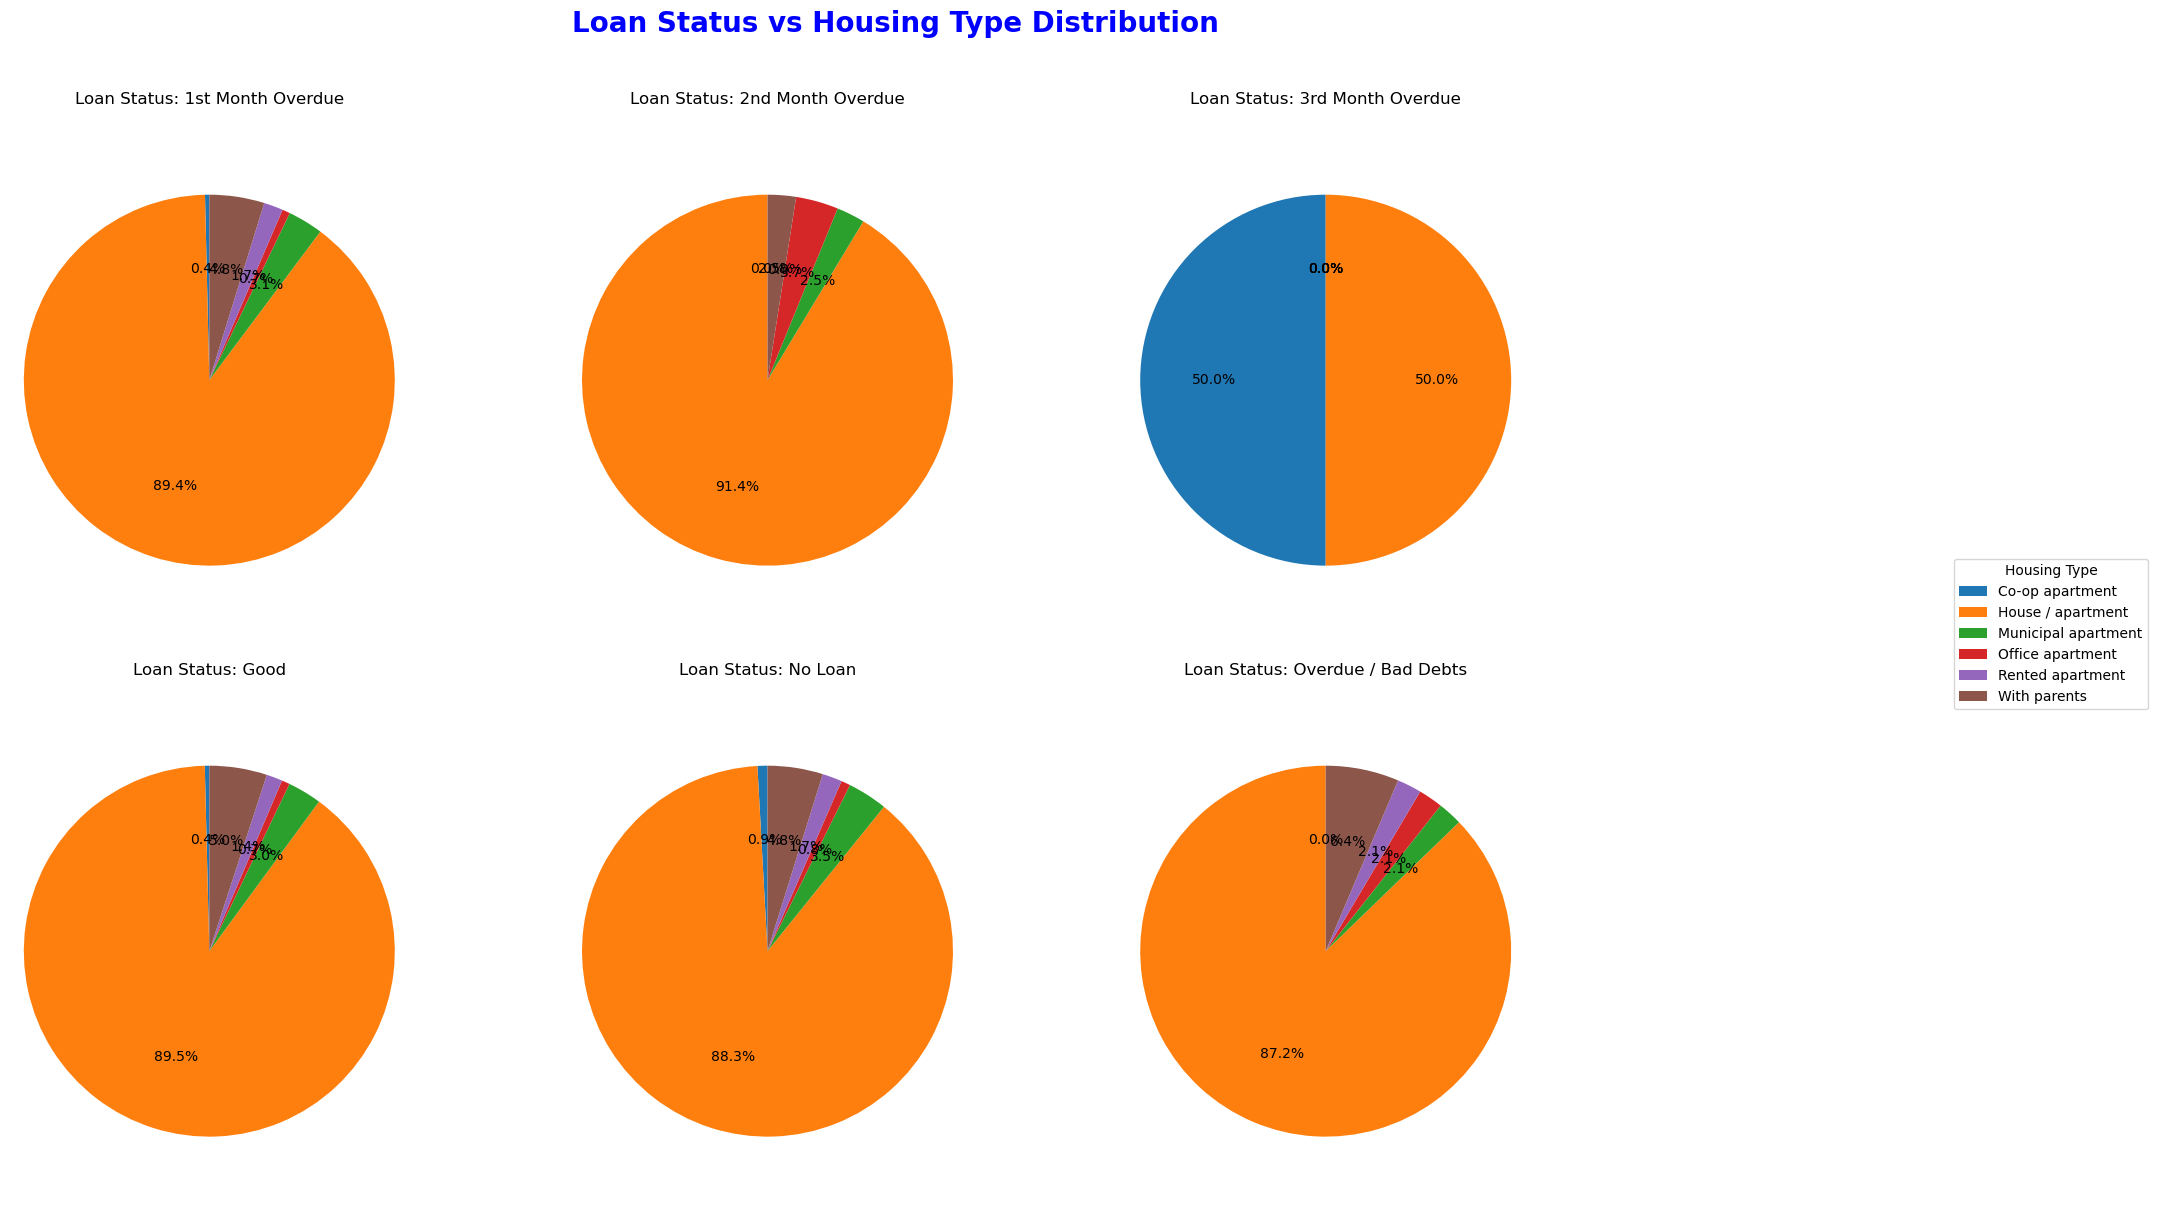

In [684]:

# Count occurrences of NAME_HOUSING_TYPE for each LOAN_STATUS
loanstatus_housingtype = df.groupby('LOAN_STATUS')['NAME_HOUSING_TYPE'].value_counts().unstack(fill_value=0)

# Determine number of rows and columns for subplots
num_categories = len(loanstatus_housingtype.index)
num_cols = 3  # Set the number of columns for better visibility
num_rows = (num_categories + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Plotting pie charts
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))

# Ensure axes is iterable
axes = axes.flatten()

# Loop through each LOAN_STATUS category
for i, status in enumerate(loanstatus_housingtype.index):
    ax = axes[i]
    sizes = loanstatus_housingtype.loc[status].values
    labels = loanstatus_housingtype.columns
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops=dict(color="w"))
    ax.set_title(f'Loan Status: {status}')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Improve label and autopct visibility
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_color('black')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a legend
fig.legend(wedges, labels, title="Housing Type", loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.suptitle('Loan Status vs Housing Type Distribution', fontsize=20, fontweight='bold', color="blue", y=1.02)
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust layout to make space for the legend
plt.show()

### Observations:

1. For every loan status except '3rd Month Overdue,' more than 85% of housing types are categorized as House/apartment.
2. Specifically, in the '3rd Month Overdue' loan status, 50% of properties are classified as 'House/apartment' and another 50% as 'Co-op apartment'.

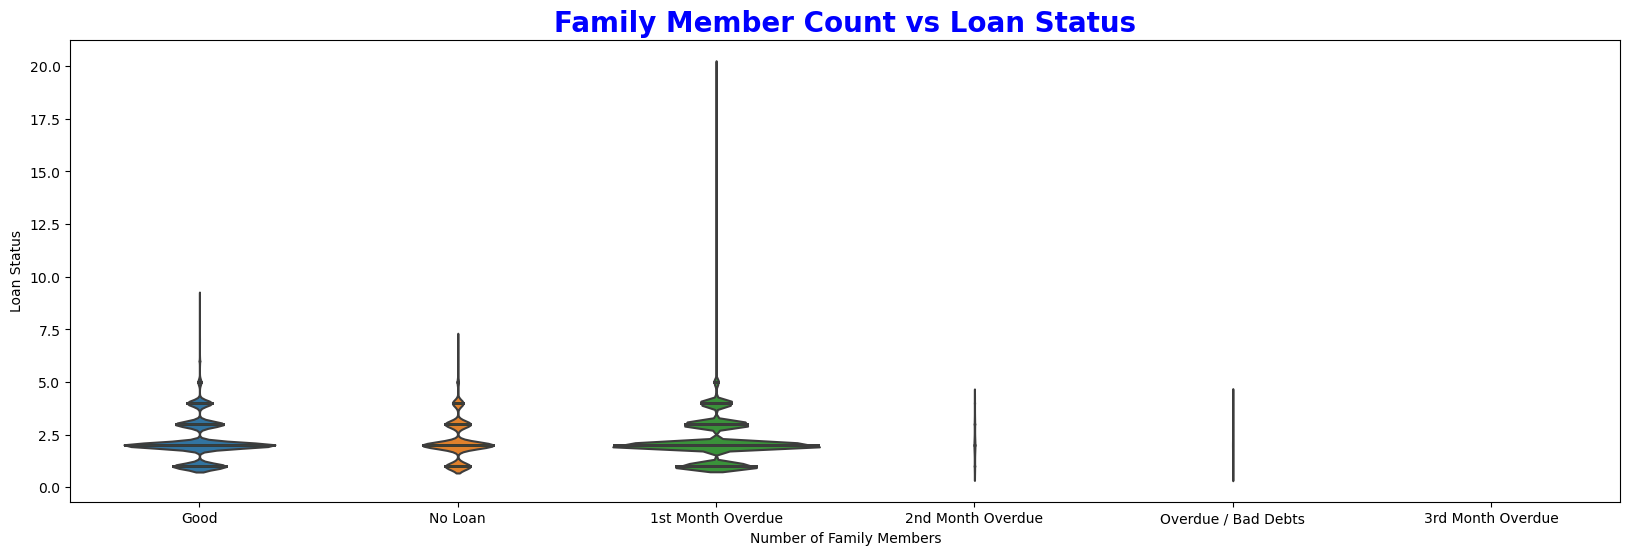

In [685]:
# df.groupby('CNT_FAM_MEMBERS')[['LOAN_STATUS']].value_counts().unstack()

# plt.figure(figsize=(15, 5))

# # plotting the countplot
# sns.countplot(data = df, x = df['CNT_FAM_MEMBERS'], hue = df['LOAN_STATUS'] )

# #plt.xticks(rotation=25)
# plt.title('Family Member vs Loan Status')

# plt.show()

# Creating the violin plot
plt.figure(figsize=(20, 6))

sns.violinplot(data=df, x='LOAN_STATUS', y='CNT_FAM_MEMBERS', scale='count', inner='stick')

plt.title('Family Member Count vs Loan Status', fontsize=20, fontweight='bold', color="blue")
plt.xlabel('Number of Family Members')
plt.ylabel('Loan Status')

plt.show()

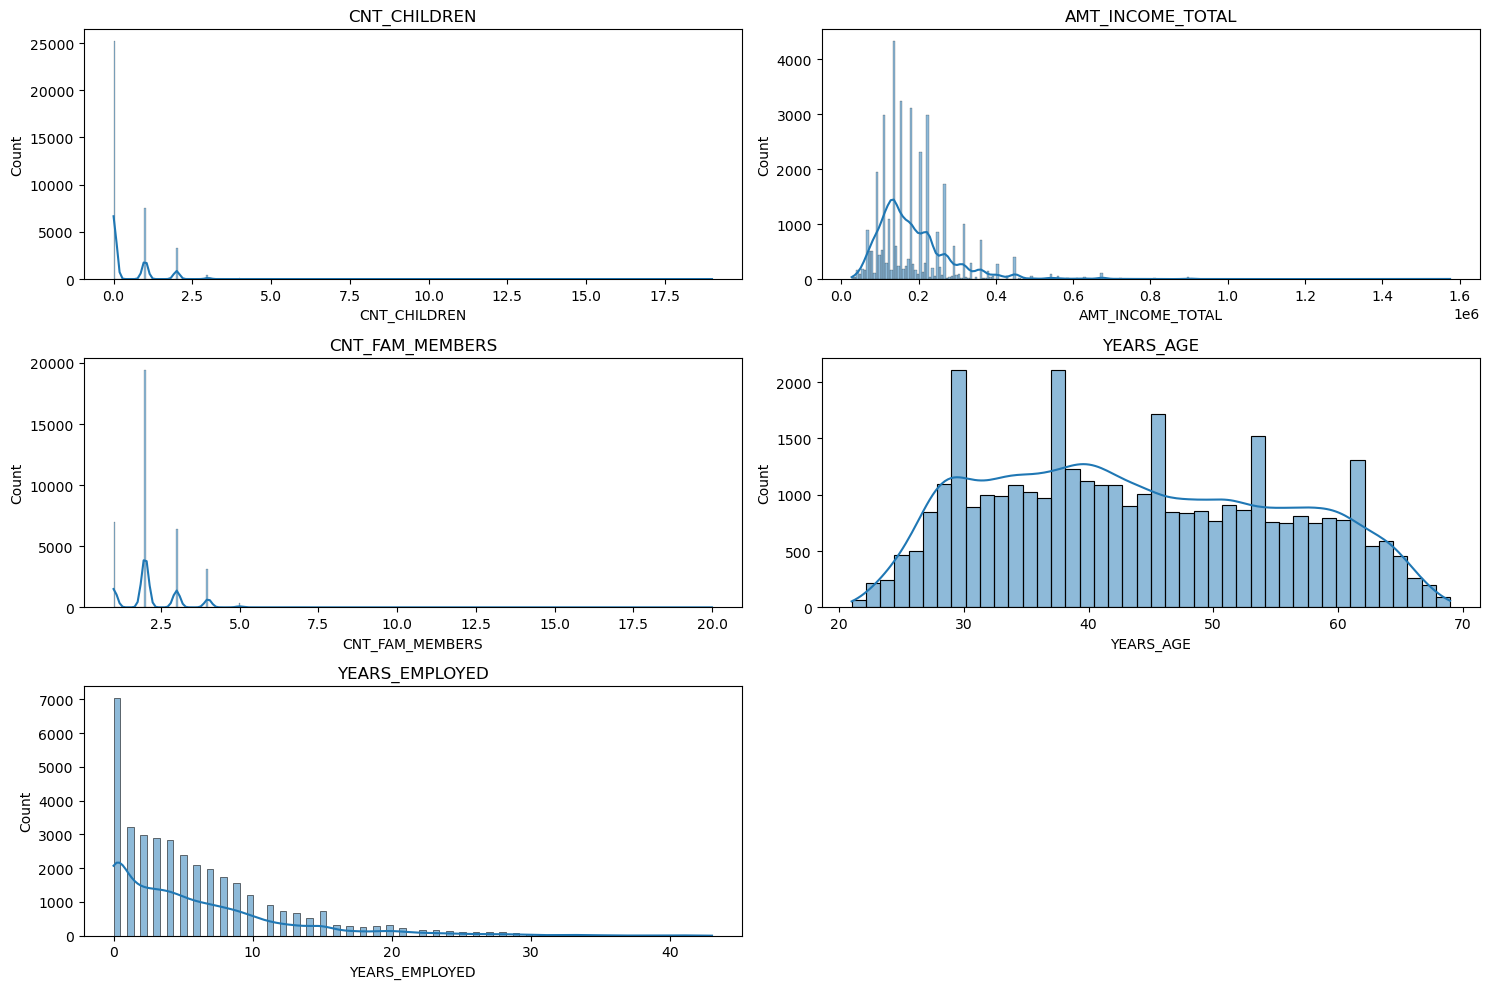

In [686]:
columns = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS','YEARS_AGE', 'YEARS_EMPLOYED']
plt.figure(figsize=(15, 10))

for i in range(len(columns)):
    plt.subplot(3, 2, i+1)
    plt.title(columns[i])
        
    sns.histplot(df[columns[i]], kde=True)
    

plt.tight_layout()
#plt.show()


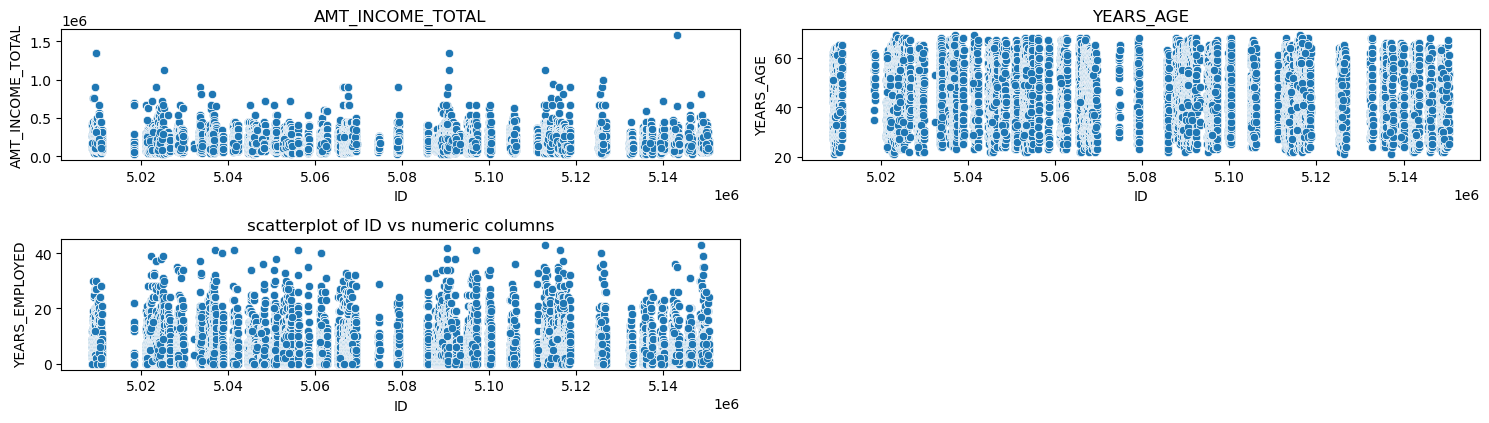

In [687]:
col = ['AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']

# defining the figure size
plt.figure(figsize=(15, 6))

# plotting the countplot using for loop
for i in range(len(col)):
    plt.subplot(3, 2, i+1)
    plt.title(col[i])  # Use the column name as the title
    sns.scatterplot(data=df, y=col[i], x='ID')
plt.title('scatterplot of ID vs numeric columns')
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

### Observations:

Besides age, variables such as number of children, family members, income, and years of employment exhibit right-skewed distributions.

Skewed distributions of features such as number of children, family size, income, and years of employment highlight the need for appropriate data preprocessing and feature engineering strategies.
    


Observation:
    


Observations:
    


Observations:
    


Data Pre Processing

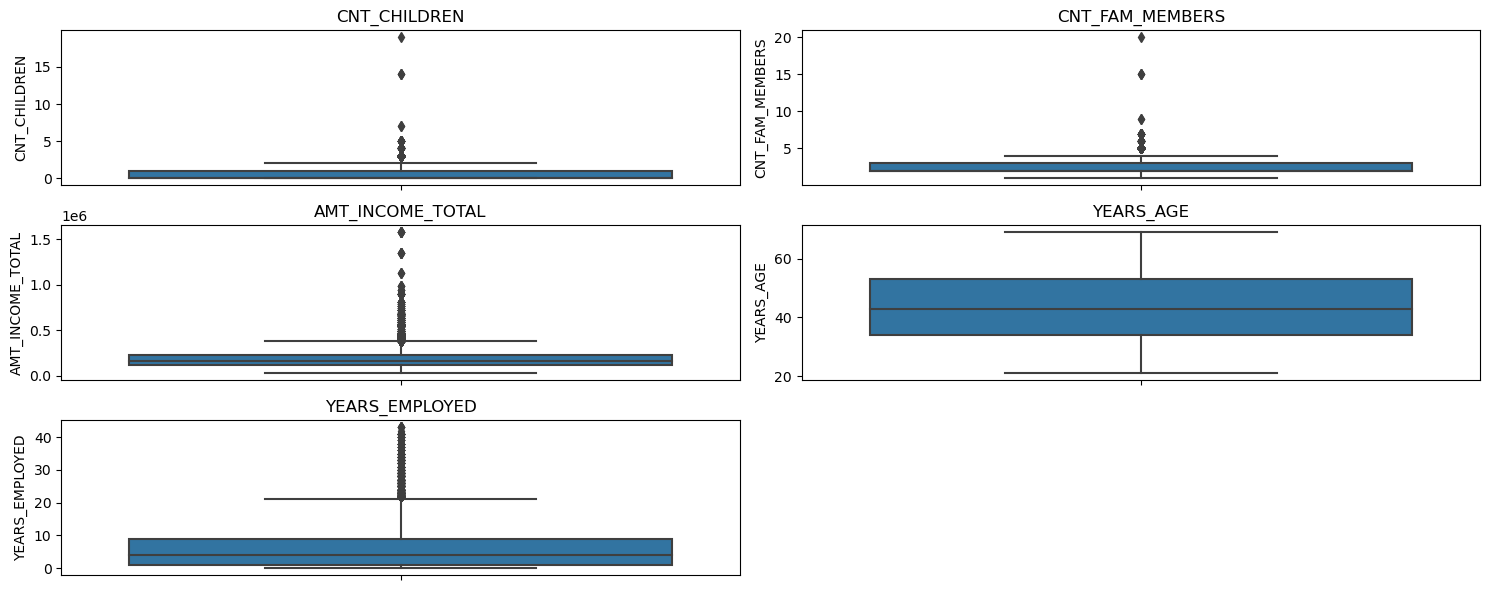

In [688]:
Columns = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS','AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']

plt.figure(figsize = (15, 6))

for i in range(len(Columns)):
    plt.subplot(3, 2, i+1)
    plt.title(Columns[i])
    sns.boxplot(data = df, y = Columns[i])


plt.tight_layout()
plt.show()

In [689]:
# removing outliers

# filtering the list of specific columns
col = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED']

# for loop to remove outliers
for i in range(len(col)):
    # calculating the first and third quartile
    q1 = df[col[i]].quantile(0.25)
    q3 = df[col[i]].quantile(0.75)
    # calculating the interquartile range
    iqr = q3 - q1
    # calculating the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # replacing the outliers with the median
    df[col[i]] = np.where((df[col[i]] >= upper_bound) | (df[col[i]] <= lower_bound), df[col[i]].median() , df[col[i]])

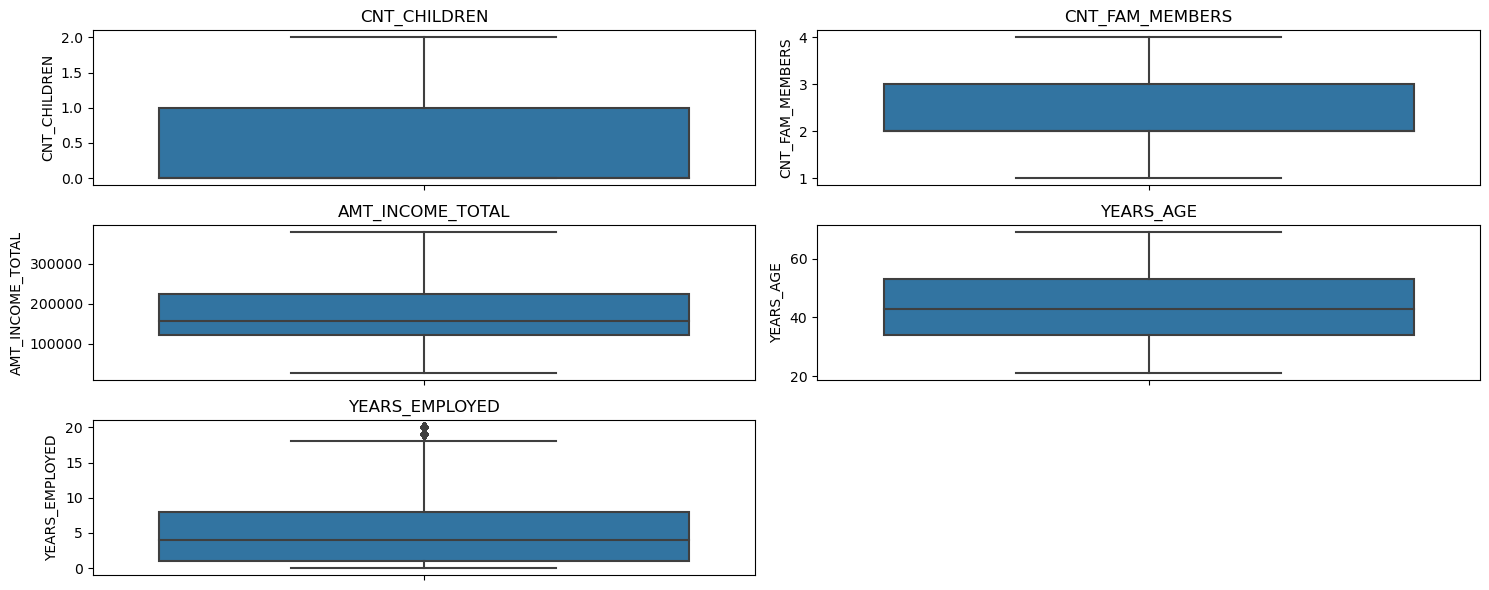

In [690]:
Columns = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS','AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']

plt.figure(figsize = (15, 6))

for i in range(len(Columns)):
    plt.subplot(3, 2, i+1)
    plt.title(Columns[i])
    sns.boxplot(data = df, y = Columns[i])


plt.tight_layout()
plt.show()

### Observations :

1. The box plot reveals numerous outliers in variables such as children, family size, income, and years of employment, all of which exhibit right-skewed distributions. 
2. After removing outliers beyond the 25th and 75th percentiles, small amount of outliers persist in the years of employment variable.

<Axes: >

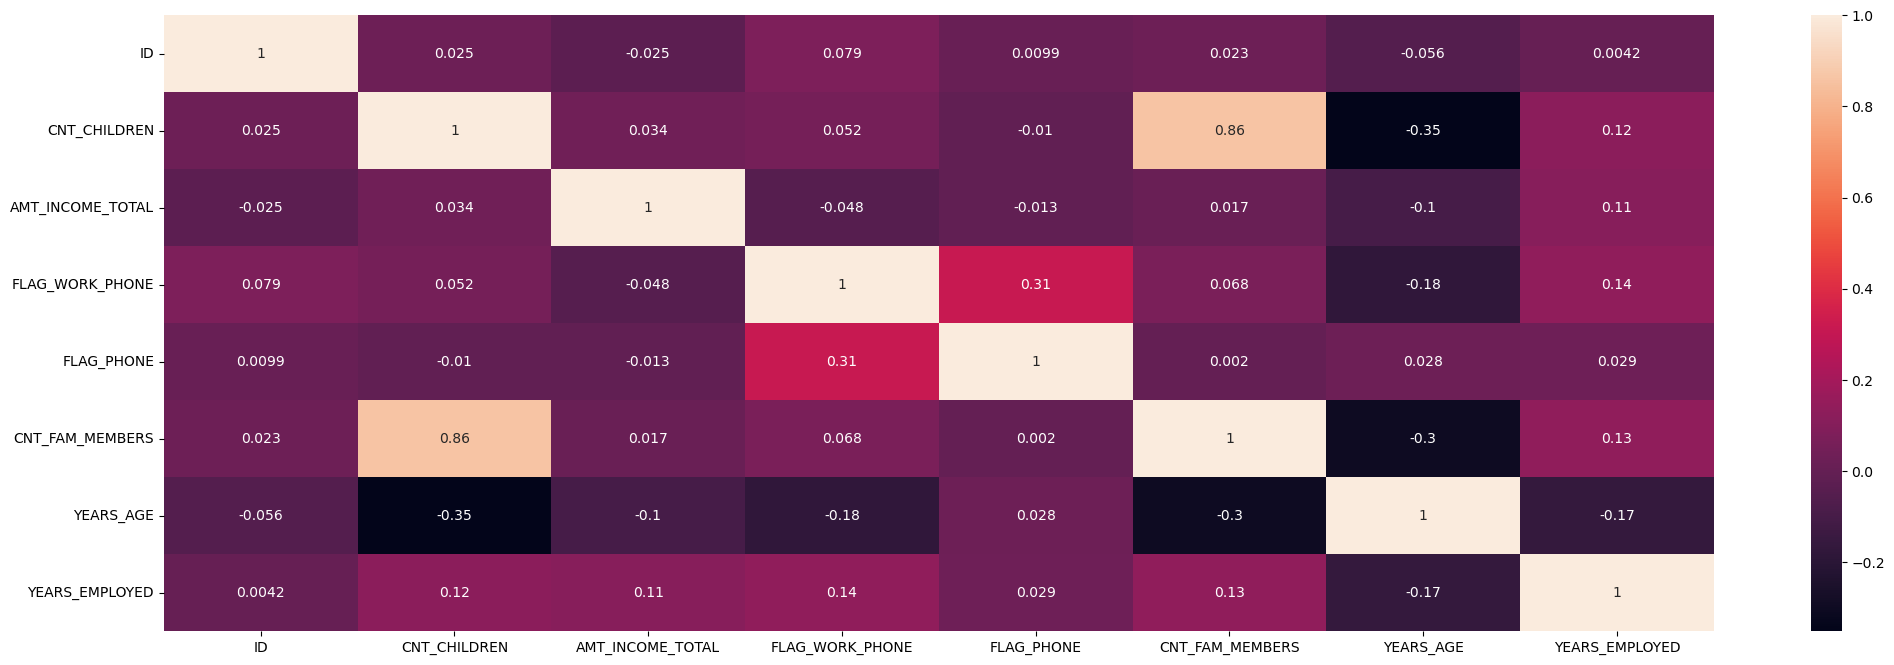

In [691]:
plt.figure(figsize=(25,8))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot = True)

### Observation

1. As we can see that children and family_members are highly correlated with each other
2. But there is no strong correlation between other numerical features
3. Hence, the condition of Independence of Observations is almost satisfied for Random Forest Classifier.

### Suitability of Model

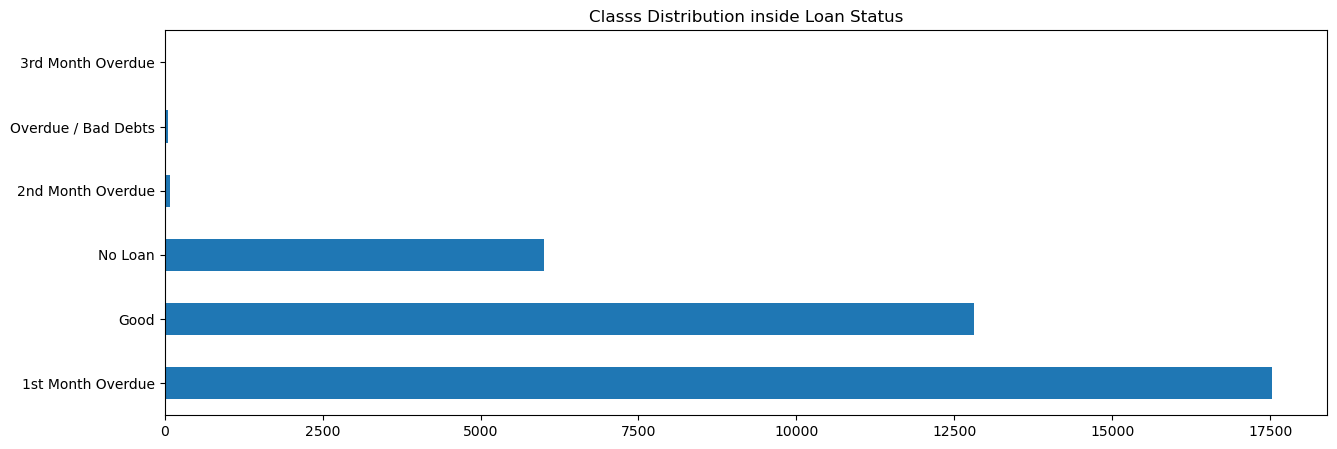

In [692]:
# checking the distribution of loan_status
df.LOAN_STATUS.value_counts().plot(kind='barh', figsize=(15, 5))
# defining the title
plt.title('Classs Distribution inside Loan Status')
plt.show()

### Observation:
    
1. The loan_status is our target variable.
2. If we see the class distribution, of our target variable loan_status, we can see that our target variable is highly imbalanced.
3. Which means that we cannot use logistic regression on our data.
4. That is why we need to use Random Forest Classifier for our model.

### Modeling & Evaluation

The target variable is highly imbalanced, which suggests the use of a Random Forest Classifier model. We will fit several models, evaluate their accuracy scores, and determine why the Random Forest Classifier is the most appropriate choice.

1. LogisticRegression
2. RandomForestClassifier
3. Support Vector Machine
4. XGBoosterClassifier

Will fit the model with Binaly and multi classification

### Binary Classification

In [693]:
df_Binary = df.copy()

In [694]:
# Delete this column as this is is a duplicate 

df_Binary = df_Binary.drop(['LOAN_STATUS'], axis=1)

In [695]:
# Create target label. We can define a 'bad' client as one having any status code in [1, 2, 3, 4, 5] in the last N months.

def create_target_label(df_Binary):
    df_Binary['TARGET'] = df_Binary['STATUS'].apply(lambda x: 1 if x in ['1', '2', '3', '4', '5'] else 0)
    return df

# Apply the function
df = create_target_label(df_Binary)

In [696]:
#Drop the STATUS column after creating the target label to avoid data leakage.

df_Binary = df_Binary.drop(['STATUS'], axis=1)

In [697]:
# Handle missing values : Fill missing values using forward fill, ensuring no missing data is left.

df_Binary.fillna(method='ffill', inplace=True)

# Encode categorical variables

label_encoders = {}
for column in df_Binary.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_Binary[column] = le.fit_transform(df_Binary[column])
    label_encoders[column] = df_Binary

In [698]:
df_Binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  int32  
 2   FLAG_OWN_CAR         36457 non-null  int32  
 3   FLAG_OWN_REALTY      36457 non-null  int32  
 4   CNT_CHILDREN         36457 non-null  float64
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  int32  
 7   NAME_EDUCATION_TYPE  36457 non-null  int32  
 8   NAME_FAMILY_STATUS   36457 non-null  int32  
 9   NAME_HOUSING_TYPE    36457 non-null  int32  
 10  FLAG_WORK_PHONE      36457 non-null  int64  
 11  FLAG_PHONE           36457 non-null  int64  
 12  OCCUPATION_TYPE      36457 non-null  int32  
 13  CNT_FAM_MEMBERS      36457 non-null  float64
 14  YEARS_AGE            36457 non-null  float64
 15  YEARS_EMPLOYED       36457 non-null 

In [699]:

X = df_Binary.drop(['ID', 'TARGET'], axis = 1) # Assume that X is our independent variable

y = df_Binary['TARGET'] # Assume that y is our dependent variable


# checking the column names of independent variable(X)
X.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'YEARS_AGE',
       'YEARS_EMPLOYED'],
      dtype='object')

In [700]:
print(f'The shpape of X ={X.shape} \n') # checking the shape of X

print(f'The shape of y ={y.shape}') # checking the shape of y

The shpape of X =(36457, 15) 

The shape of y =(36457,)


In [701]:
#Split the data into training and test sets, ensuring stratification to handle class imbalance.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)



### Observation:

1. We have splitted the dataset into 80% train and 20% test
2. 80% of our dataset is used for training
3. 20% of our dataset is used for testing

In [702]:
#Apply SMOTE to handle the class imbalance in the training set.

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [703]:
#Define and train the logistic regression model
model = LogisticRegression(max_iter=1000)

model.fit(X_train_res,  y_train_res)

# making predictions on the test set
y_pred = model.predict(X_test)

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

C:\Users\sonal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Actual,Predicted
21900,0,0
24293,0,0
19633,0,1
2496,0,1
25932,0,0
6267,0,0
6281,0,0
12287,0,0
14957,0,1
22040,0,0


In [704]:
#Evaluating the Model : 
#Make predictions on the test set and evaluate the model’s performance using accuracy, precision, recall, and F1-score.


print('Logistic Model  Train Accuracy : ',model.score(X_train_res, y_train_res)*100, '%')
print('Logistic Model Test Accuracy : ', model.score(X_test, y_test)*100, '%')

print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

Logistic Model  Train Accuracy :  72.84332954819173 %
Logistic Model Test Accuracy :  73.38178826110806 %
Accuracy Score : 73.38 %
Precision Score : 0.73
F1-Score : 0.7338178826110806
recall : 0.7338178826110806
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      7266
           1       0.00      0.27      0.01        26

    accuracy                           0.73      7292
   macro avg       0.50      0.50      0.43      7292
weighted avg       0.99      0.73      0.84      7292



### Observations:

The results from the logistic regression model show that it performs poorly in predicting the minority class. This is evident from the very low precision, recall, and F1-score for class 1. The overall accuracy is not a good metric.

In [705]:
# making predictions on the test set# Initialize Random Forest classifier
#Ran_Forest_binary = RandomForestClassifier(random_state=42)

Ran_Forest_binary = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 100})  # Adjust the weights

# fitting the model
Ran_Forest_binary.fit(X_train_res,  y_train_res)

y_pred = Ran_Forest_binary.predict(X_test)

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

,Actual,Predicted
21900,0,0
24293,0,0
19633,0,0
2496,0,0
25932,0,0
6267,0,0
6281,0,0
12287,0,0
14957,0,0
22040,0,0


In [706]:
#Evaluating the Model : 
#Make predictions on the test set and evaluate the model’s performance using accuracy, precision, recall, and F1-score.

print('Random Forest Model  Train Accuracy : ',Ran_Forest_binary.score(X_train_res, y_train_res)*100, '%')
print('Random Forest Model Test Accuracy : ', Ran_Forest_binary.score(X_test, y_test)*100, '%')

print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

Random Forest Model  Train Accuracy :  99.64729362375692 %
Random Forest Model Test Accuracy :  99.06747120131652 %
Accuracy Score : 99.07 %
Precision Score : 0.99
F1-Score : 0.9906747120131651
recall : 0.9906747120131651
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7266
           1       0.11      0.23      0.15        26

    accuracy                           0.99      7292
   macro avg       0.55      0.61      0.57      7292
weighted avg       0.99      0.99      0.99      7292



### Observations:

The results from your Random Forest model indicate that it is performing well on the majority class (0), but poorly on the minority class (1). This is evident from the low precision, recall, and F1-score for class 1, despite high overall accuracy and metrics for class 0.

To ensure that the high metrics are accurate and not due to an issue such as class imbalance not being properly handled.

##### 1. Confusion Matrix Analysis: Confirm the number of true positives, true negatives, false positives, and false negatives.
##### 2. Cross-Validation: Perform cross-validation to ensure robustness.
##### 3. Feature Importance: Investigate feature importance to understand which features are driving the predictions.
##### 4. Hyperparameter Tuning: Fine-tune hyperparameters to potentially improve the model further.

In [707]:
# Cross Validation ensure that your model's performance is consistent and robust across different subsets of the data.

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(Ran_Forest_binary, X, y, cv=5)

print(f'Cross-validation scores: {cross_val_scores}')
print(f'Mean cross-validation score: {cross_val_scores.mean()}')

Cross-validation scores: [0.99547449 0.99040044 0.98847895 0.99163352 0.99039912]
Mean cross-validation score: 0.9912773042125517


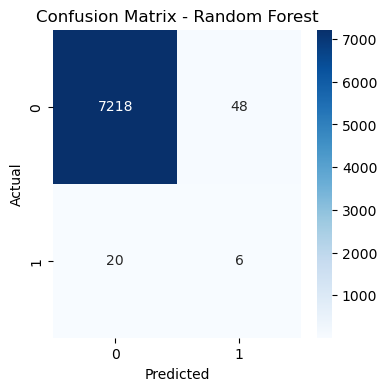

In [708]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

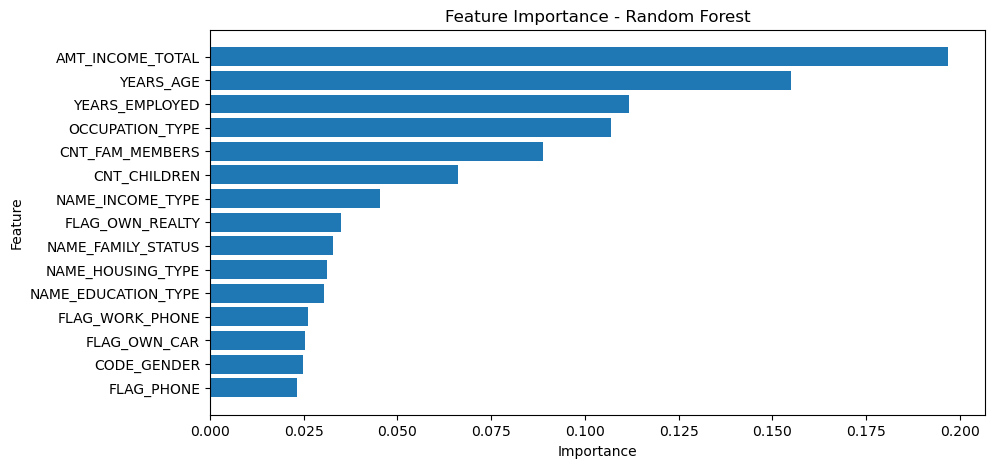

In [709]:
# Predict probabilities
y_proba = Ran_Forest_binary.predict_proba(X_test)[:, 1]

# Random Forest feature importance
rf_importance = Ran_Forest_binary.feature_importances_
features_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importance})
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(features_importance_df['Feature'], features_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.show()

### Observations :

1. Upon reviewing the Feature Importance plot above, it is evident that 'Total Income' exerts the strongest influence. Additionally, notable influencing factors include 'Age,' 'Occupation Type,' 'Years of Employment,' and 'Family members.

2. Suggetion : Further enhancement of the model necessitates Hyperparameter Tuning.


In [710]:
# Define and train SVM model
svc_model = LinearSVC()
svc_model.fit(X_train_res,  y_train_res)

y_pred = svc_model.predict(X_test)

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

,Actual,Predicted
21900,0,0
24293,0,0
19633,0,1
2496,0,1
25932,0,0
6267,0,0
6281,0,0
12287,0,0
14957,0,1
22040,0,0


In [711]:
print('Support Vector Classifier Model  Train Accuracy : ',svc_model.score(X_train_res, y_train_res)*100, '%')
print('Support Vector Classifier Model Test Accuracy : ', svc_model.score(X_test, y_test)*100, '%')

print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

Support Vector Classifier Model  Train Accuracy :  74.49330718144593 %
Support Vector Classifier Model Test Accuracy :  74.67087218869995 %
Accuracy Score : 74.67 %
Precision Score : 0.75
F1-Score : 0.7467087218869994
recall : 0.7467087218869994
              precision    recall  f1-score   support

           0       1.00      0.75      0.85      7266
           1       0.00      0.27      0.01        26

    accuracy                           0.75      7292
   macro avg       0.50      0.51      0.43      7292
weighted avg       0.99      0.75      0.85      7292



### Observation:

The SVC model achieved an accuracy of 74.67% but showed extremely low precision (0.00) and recall (0.27) for the minority class, highlighting its bias towards the majority class.
Despite some identification of positive cases, the SVC model's performance on the minority class remains inadequate.

In [712]:
# Define the XGBoost model
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Debug: Check the unique values in the predictions
print("Unique values in the predictions:")
print(pd.Series(y_pred).value_counts())

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

Unique values in the predictions:
0    5457
1    1835
dtype: int64


,Actual,Predicted
21900,0,0
24293,0,0
19633,0,1
2496,0,1
25932,0,0
6267,0,0
6281,0,0
12287,0,0
14957,0,1
22040,0,0


In [713]:
print('XGBoost  Train Accuracy : ',xgb_model.score(X_train_res, y_train_res)*100, '%')
print('XGBoost Model Test Accuracy : ', xgb_model.score(X_test, y_test)*100, '%')



print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

XGBoost  Train Accuracy :  54.43377722721172 %
XGBoost Model Test Accuracy :  99.6023038946791 %
Accuracy Score : 74.67 %
Precision Score : 0.75
F1-Score : 0.7467087218869994
recall : 0.7467087218869994
              precision    recall  f1-score   support

           0       1.00      0.75      0.85      7266
           1       0.00      0.27      0.01        26

    accuracy                           0.75      7292
   macro avg       0.50      0.51      0.43      7292
weighted avg       0.99      0.75      0.85      7292



### Observations:

XGBoost shows a discrepancy with reported high accuracy (99.60%) but struggles with identifying the minority class, evident from its low precision (0.00) and moderate recall (0.27).While achieving strong performance in predicting the majority class, XGBoost's effectiveness is limited by its inability to adequately identify positive cases.

### Multiclassification

In [714]:
df_Multi = df.copy()

In [715]:
df_Multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  float64
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  FLAG_WORK_PHONE      36457 non-null  int64  
 11  FLAG_PHONE           36457 non-null  int64  
 12  OCCUPATION_TYPE      25134 non-null  object 
 13  CNT_FAM_MEMBERS      36457 non-null  float64
 14  STATUS               36457 non-null  object 
 15  YEARS_AGE            36457 non-null 

In [716]:
#Drop the STATUS column as considered the LOAN_STATUS is the target label to avoid data leakage.

df_Multi = df_Multi.drop(['STATUS'], axis=1)

In [717]:
# Handle missing values : Fill missing values using forward fill, ensuring no missing data is left.

df_Multi.fillna(method='ffill', inplace=True)

# Encode categorical variables
label_encoders = {}
for column in df_Multi.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_Multi[column] = le.fit_transform(df_Multi[column])
    label_encoders[column] = le

    
# Select features and target
X = df_Multi.drop(columns=['ID', 'LOAN_STATUS'])
y = df_Multi['LOAN_STATUS']

# Check class distribution
print("Class distribution in the target variable:")
print(y.value_counts())


#, stratify=y
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check class distribution in training and testing sets
print("Class distribution in y_train:")
print(y_train.value_counts())
print("Class distribution in y_test:")
print(y_test.value_counts())

Class distribution in the target variable:
0    17522
3    12807
4     5998
1       81
5       47
2        2
Name: LOAN_STATUS, dtype: int64
Class distribution in y_train:
0    12341
3     8926
4     4168
1       51
5       31
2        2
Name: LOAN_STATUS, dtype: int64
Class distribution in y_test:
0    5181
3    3881
4    1830
1      30
5      16
Name: LOAN_STATUS, dtype: int64


In [718]:
# Handle class imbalance with SMOTE
# Adjust k_neighbors based on the distribution of the target variable


smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)  # Adjust k_neighbors as needed
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


print("Class distribution in y_train_res after SMOTE:")
print(pd.Series(y_train_res).value_counts())

Class distribution in y_train_res after SMOTE:
4    12341
0    12341
3    12341
5    12341
1    12341
2    12341
Name: LOAN_STATUS, dtype: int64


In [719]:
#Define and train the logistic regression model
Log_Reg_multi = LogisticRegression(max_iter=1000)

Log_Reg_multi.fit(X_train_res,  y_train_res)

# making predictions on the test set
y_pred = Log_Reg_multi.predict(X_test)

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

C:\Users\sonal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Actual,Predicted
21900,3,1
24293,3,5
19633,0,4
2496,0,5
25932,4,2
6267,0,0
6281,0,5
12287,0,0
14957,0,3
22040,3,4


In [720]:
print('Linear Model  Train Accuracy : ',Log_Reg_multi.score(X_train_res, y_train_res)*100, '%')
print('Linear Model Test Accuracy : ', Log_Reg_multi.score(X_test, y_test)*100, '%')

print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

Linear Model  Train Accuracy :  39.26883288766442 %
Linear Model Test Accuracy :  19.49168038032547 %
Accuracy Score : 19.49 %
Precision Score : 0.19
F1-Score : 0.1949168038032547
recall : 0.1949168038032547
              precision    recall  f1-score   support

           0       0.48      0.28      0.35      5181
           1       0.00      0.03      0.00        30
           2       0.00      0.00      0.00         0
           3       0.35      0.14      0.20      3881
           4       0.16      0.08      0.11      1830
           5       0.00      0.44      0.00        16

    accuracy                           0.19     10938
   macro avg       0.17      0.16      0.11     10938
weighted avg       0.38      0.19      0.26     10938



### Observation:

1. The linear model shows poor performance with a low overall accuracy of 19.49%, indicating significant difficulty in correctly predicting outcomes.

2. Precision and recall vary widely across classes, with notable challenges in correctly identifying classes 1, 2, and 5, suggesting the model's struggle with class imbalance and insufficient predictive power.

3. The macro-average F1-score of 0.11 indicates overall poor performance across classe.

In [721]:
# Initialize Random Forest classifier
Ran_Forest_multi = RandomForestClassifier(random_state=42)

# fitting the model
Ran_Forest_multi.fit(X_train_res,  y_train_res)

# making predictions on the test set
y_pred = Ran_Forest_multi.predict(X_test)

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

,Actual,Predicted
21900,3,3
24293,3,0
19633,0,0
2496,0,3
25932,4,4
6267,0,3
6281,0,0
12287,0,3
14957,0,0
22040,3,0


In [722]:
print('Random Forest Model  Train Accuracy : ',Ran_Forest_multi.score(X_train_res, y_train_res)*100, '%')
print('Random Forest Model Test Accuracy : ', Ran_Forest_multi.score(X_test, y_test)*100, '%')


print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

Random Forest Model  Train Accuracy :  90.60854063690138 %
Random Forest Model Test Accuracy :  55.59517279210093 %
Accuracy Score : 55.60 %
Precision Score : 0.56
F1-Score : 0.5559517279210093
recall : 0.5559517279210093
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      5181
           1       0.29      0.13      0.18        30
           3       0.53      0.54      0.53      3881
           4       0.43      0.48      0.45      1830
           5       0.33      0.25      0.29        16

    accuracy                           0.56     10938
   macro avg       0.44      0.40      0.41     10938
weighted avg       0.56      0.56      0.56     10938



### Observation:

1. The Random Forest model achieves a moderate test accuracy of 55.60%, indicating some ability to predict outcomes, though room for improvement remains.

2. Precision and recall vary across classes, with better performance seen in predicting class 0 (precision 0.63, recall 0.60) compared to other classes such as 1 and 5, where performance is notably lower.

3. The macro-average F1-score of 0.41 suggests fair overall performance across classes, indicating the model's effectiveness varies by class and could benefit from further tuning or feature engineering to enhance predictive accuracy.

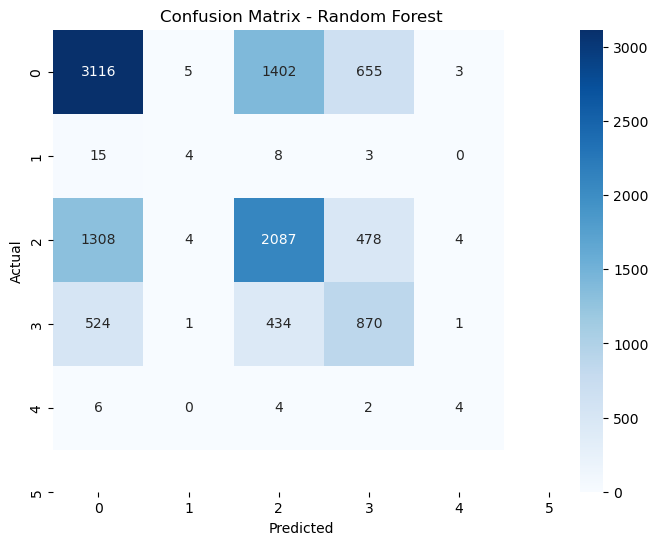

In [723]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

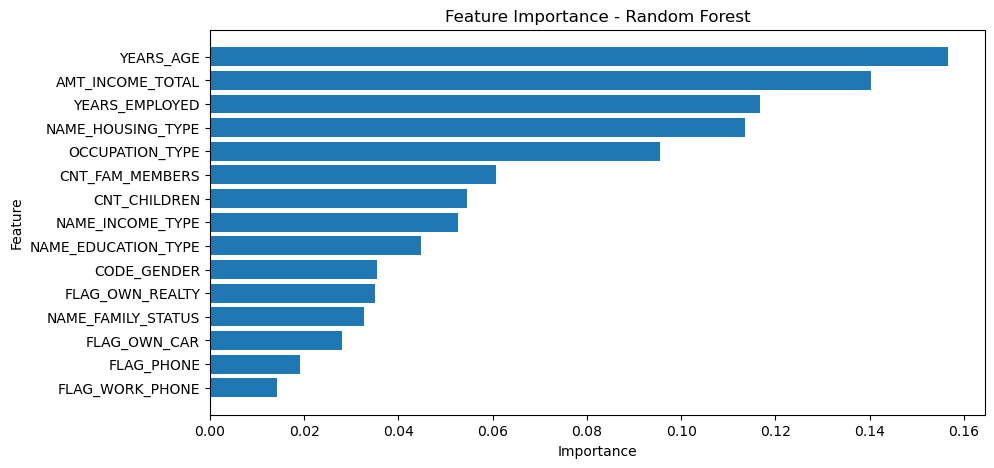

In [724]:
# Predict probabilities
y_proba = Ran_Forest_multi.predict_proba(X_test)[:, 1]

# Random Forest feature importance
rf_importance = Ran_Forest_multi.feature_importances_
features_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importance})
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(features_importance_df['Feature'], features_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.show()

### Observations:

Upon reviewing the Feature Importance plot above for multiclassification, it is evident that 'Age' exerts the strongest influence. Additionally, notable influencing factors include 'Total Income', 'Years of Employment', 'Housing Type', and 'Occupation Type' respectively.


In [725]:
# Define and train SVM model
svm_linear_multi = LinearSVC()
svm_linear_multi.fit(X_train_res,  y_train_res)

y_pred = svm_linear_multi.predict(X_test)

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

,Actual,Predicted
21900,3,1
24293,3,5
19633,0,4
2496,0,1
25932,4,1
6267,0,5
6281,0,5
12287,0,5
14957,0,5
22040,3,4


In [726]:
print('Supply Vector Machine Model  Train Accuracy : ',svm_linear_multi.score(X_train_res, y_train_res)*100, '%')
print('Supply Vector Machine Model Test Accuracy : ', svm_linear_multi.score(X_test, y_test)*100, '%')


print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

Supply Vector Machine Model  Train Accuracy :  26.239094616859788 %
Supply Vector Machine Model Test Accuracy :  4.196379594075699 %
Accuracy Score : 4.20 %
Precision Score : 0.04
F1-Score : 0.04196379594075699
recall : 0.04196379594075699
              precision    recall  f1-score   support

           0       0.65      0.01      0.02      5181
           1       0.00      0.30      0.01        30
           2       0.00      0.00      0.00         0
           3       0.38      0.04      0.07      3881
           4       0.17      0.14      0.15      1830
           5       0.00      0.44      0.00        16

    accuracy                           0.04     10938
   macro avg       0.20      0.15      0.04     10938
weighted avg       0.47      0.04      0.06     10938



### Observations:

##### Performance Metrics:

1. The SVM model demonstrates very poor performance with a test accuracy of 4.20%, indicating severe challenges in predicting the correct outcomes in multiclassification.
2. Precision and recall are extremely low across most classes, with notable difficulties in predicting classes 0, 3, and 4.

##### Class-specific Insights:

1. Class 0 shows slightly better precision (0.65) but very low recall (0.01), indicating the model's inability to correctly identify instances of this class.
2. Class 1 has better recall (0.30) but lacks precision (0.00), suggesting frequent false positives.

In [727]:
# Define the XGBoost model
xgb_model_multi = XGBClassifier()

# Train the model
xgb_model_multi.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model_multi.predict(X_test)

# Debug: Check the unique values in the predictions
print("Unique values in the predictions:")
print(pd.Series(y_pred).value_counts())

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

Unique values in the predictions:
5    5781
1    2639
4    1457
2     595
3     404
0      62
dtype: int64


,Actual,Predicted
21900,3,1
24293,3,5
19633,0,4
2496,0,1
25932,4,1
6267,0,5
6281,0,5
12287,0,5
14957,0,5
22040,3,4


In [728]:
print('XGBoost Model  Train Accuracy : ',xgb_model_multi.score(X_train_res, y_train_res)*100, '%')
print('XGBoost Model Test Accuracy : ', xgb_model_multi.score(X_test, y_test)*100, '%')


print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")
print(f"recall : {recall_score(y_test, y_pred, average='micro')}")

print(classification_report(y_test, y_pred, zero_division=0))

XGBoost Model  Train Accuracy :  37.033735785862845 %
XGBoost Model Test Accuracy :  53.15414152495887 %
Accuracy Score : 4.20 %
Precision Score : 0.04
F1-Score : 0.04196379594075699
recall : 0.04196379594075699
              precision    recall  f1-score   support

           0       0.65      0.01      0.02      5181
           1       0.00      0.30      0.01        30
           2       0.00      0.00      0.00         0
           3       0.38      0.04      0.07      3881
           4       0.17      0.14      0.15      1830
           5       0.00      0.44      0.00        16

    accuracy                           0.04     10938
   macro avg       0.20      0.15      0.04     10938
weighted avg       0.47      0.04      0.06     10938



### Observations:

##### Performance Metrics:

1. The XGBoost model exhibits very poor performance with a test accuracy of 4.20%, indicating significant challenges in correctly predicting the outcomes.
2. Precision and recall scores are extremely low across most classes, suggesting the model struggles to effectively classify instances.

##### Class-specific Insights:

1. Class 0 shows marginally better precision (0.65) but very low recall (0.01), indicating the model's difficulty in identifying instances of this class correctly.
2. Class 1 has higher recall (0.30) but lacks precision (0.00), which implies numerous false positives.

## Final Observation


**The Random Forest model demonstrated strong performance in binary classification, achieving high accuracy on both the training (99.65%) and test (99.07%) datasets. This indicates robust predictive capability across different data subsets.

**There is potential for this model to assist banks in distinguishing between creditworthy clients and those who may pose a higher risk when assessing credit card applications.

### Detail observation on Random Forest Model Evaluation

##### Accuracy: 
The model shows high accuracy on both training (99.65%) and test (99.07%) datasets, indicating good overall performance in predicting the correct class.

##### Precision and Recall:
Precision for class 1 (minority class) is 0.99, which means when the model predicts a positive (1), it is correct 99% of the time.
Recall for class 1 is also 0.99, indicating that the model correctly identifies 99% of all actual positives.

##### F1-Score:
The F1-score, which balances precision and recall, is 0.99 for class 1. This suggests that the model performs well in terms of both precision and recall for the minority class.

##### Class Imbalance:
There is a significant class imbalance, as indicated by the support values: 7266 instances of class 0 (majority class) and only 26 instances of class 1 (minority class).
The macro-average and weighted-average metrics show a lower performance for class 1 due to its lower support and imbalanced nature.

##### Differences in Feature Importance:

1. There are noticeable variations in feature importance between binary and multiclass classifications.
2. For binary classification, 'Total Income' takes precedence, suggesting its critical role in predicting the outcome.
3. In contrast, multiclassification emphasizes 'Age' as the top feature, indicating its broader impact across multiple outcome categories.

Notes:
These differences underscore the importance of tailoring feature selection and model interpretation to the specific classification task at hand, whether predicting a single binary outcome or multiple categorical outcomes. Adjusting model strategies based on these insights can enhance predictive accuracy and model understanding accordingly.


### Future Suggations:

Hyperparameter Tuning: Once identifies the important features, can do further fine-tune the Random Forest model using Grid Search or Random Search to optimize hyperparameters.


### Actions Considered :

1. Constructed a Confusion Matrix to verify the counts of true positives, true negatives, false positives, and false negatives.
2. Implemented Cross-Validation to enhance model robustness and reliability.
3. Utilized Feature Importance analysis to discern influential features driving model predictions.
4. Attempted Hyperparameter tuning using Grid Search and Random Search, although the prolonged process led to system crashes, hindering further refinement to ensure robust metrics and address potential issues like unbalanced classes.